# Working Notebook

In [1]:
import torch
from time_deconv.time_deconv_simulator import *
from time_deconv.time_deconv import *
from time_deconv.hypercluster import *
from time_deconv.evaluation import *

# Configure

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

n_iters = 1000

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)

In [5]:
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [7]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc',
    hypercluster = False,
)

/home/nbarkas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


type of selected_genes: <class 'list'>


# Run Deconvolution

In [8]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype
)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000)

[step: 0, time: 1 s ] loss: 30365557.04


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

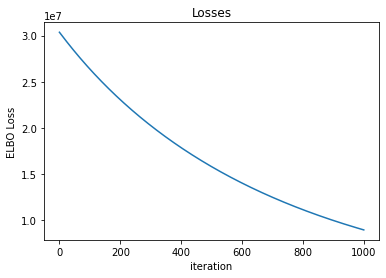

In [10]:
# plot the losses
pseudo_time_reg_deconv.plot_loss()

In [11]:
r = pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000, return_vals=True)

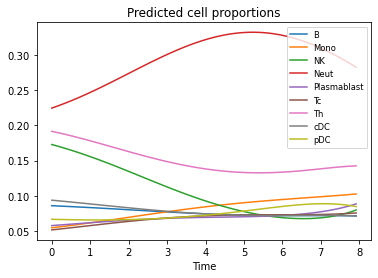

In [12]:
pseudo_time_reg_deconv.plot_composition_trajectories(show_hypercluster=True)

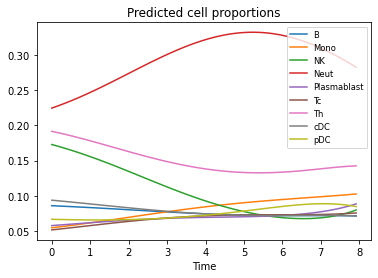

In [13]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

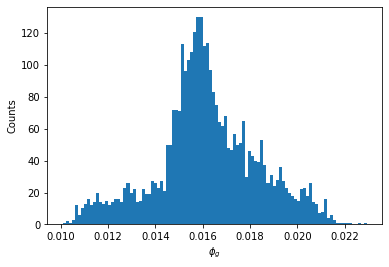

In [14]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

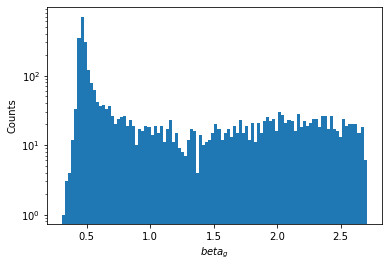

In [15]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Plot per sample deconvolution

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

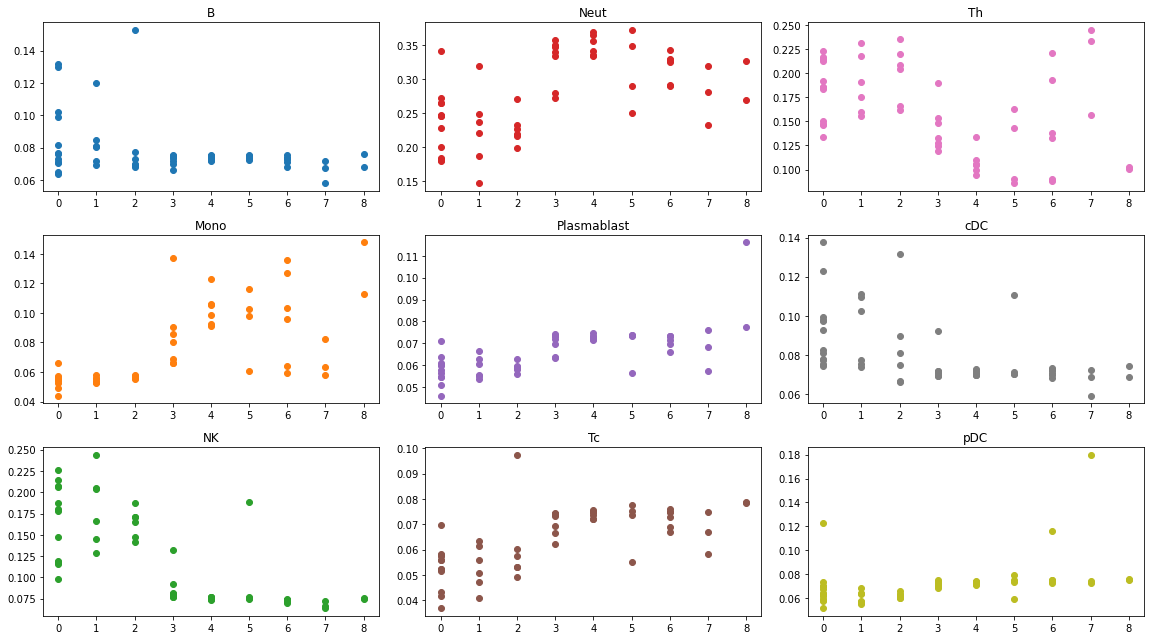

In [17]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()

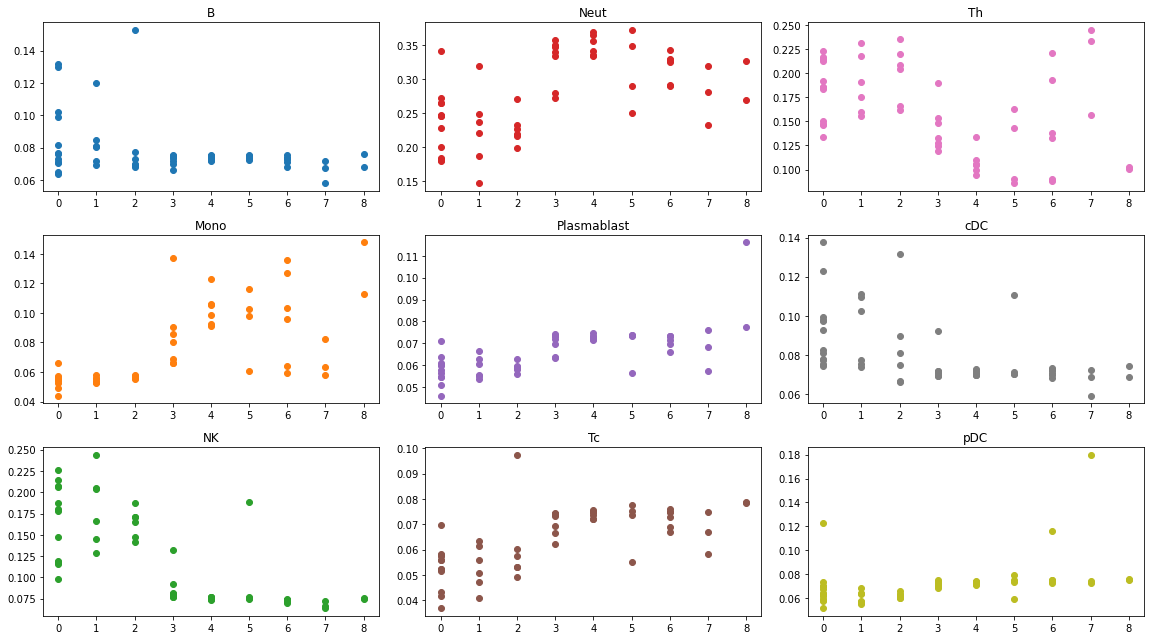

In [18]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter(ignore_hypercluster=True)
matplotlib.pyplot.show()

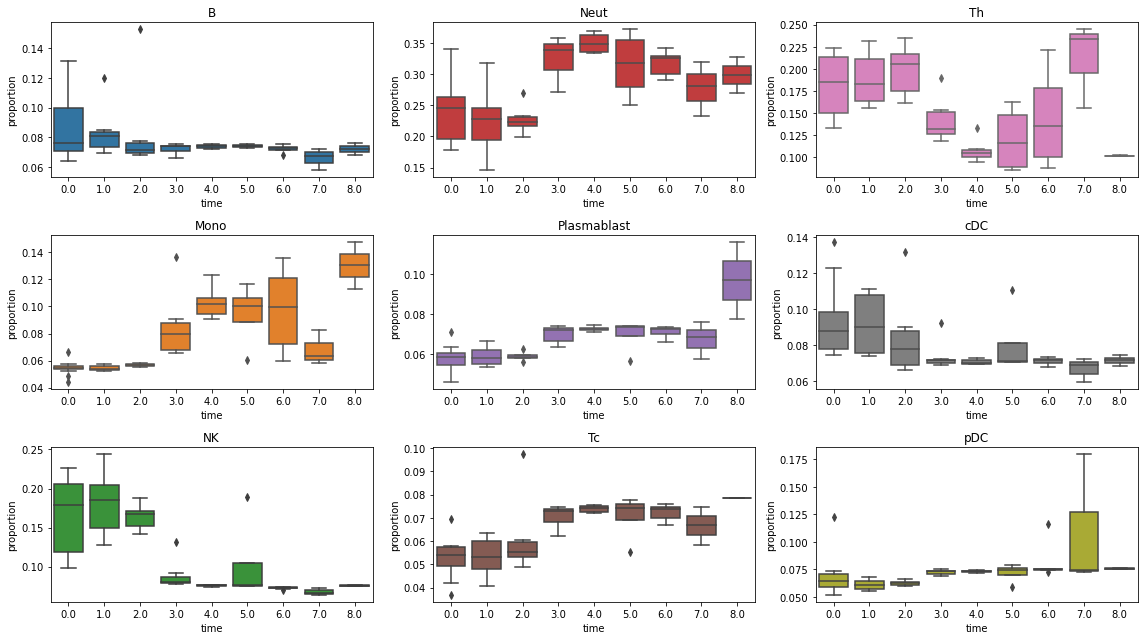

In [19]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()

# Exporting

In [33]:

cell_pop_mc = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu()

col_sample = []
col_celltype = []
col_proportion = []

for i_0 in range(cell_pop_mc.shape[0]):
    for i_1 in range(cell_pop_mc.shape[1]):
        col_sample.append(pseudo_time_reg_deconv.dataset.bulk_sample_names[i_0])
        col_celltype.append(pseudo_time_reg_deconv.dataset.cell_type_str_list[i_1])
        col_proportion.append(cell_pop_mc[i_0, i_1].item())
    
results_df = pd.DataFrame({'col_sample': col_sample, 'col_celltype': col_celltype, 'col_proportion': col_proportion})

In [34]:
results_df.to_csv('~/file1.csv')

In [ ]:
pseudo_time_reg_deconv.write_sample_compositions('export_file1.csv')